## Test Script for Retinal Vessel Segmentation

In [1]:
#!pip install -q git+https://github.com/qubvel/segmentation_models.git

In [2]:
# Import Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import segmentation_models as sm
from glob import glob
from skimage import exposure, filters, io, color

Segmentation Models: using `keras` framework.


In [3]:
# Ensure segmentation_models is using the correct framework
sm.set_framework('tf.keras')

In [4]:
# Set memory growth to avoid OOM errors
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [5]:
# Define constants (should match training script)
INPUT_SHAPE = (512, 512, 3)
PREPROCESSING = "CLAHE" 
MODEL_PATH = "models" 

In [14]:
# Custom objects for loading the model
# ========================== Custom Loss Functions ==========================

def dice_loss(y_true, y_pred):
    """
    Compute Dice loss for binary segmentation tasks.

    Dice loss is particularly useful for imbalanced class problems in segmentation, 
    focusing on the overlap between the predicted and true masks.

    Args:
        y_true (tf.Tensor): Ground truth binary mask tensor.
        y_pred (tf.Tensor): Predicted binary mask tensor.

    Returns:
        tf.Tensor: Dice loss value.
    """
    smooth = 1.0  # Smoothing factor to avoid division by zero
    y_true_f = tf.reshape(y_true, [-1])  # Flatten the tensors
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    return 1 - (2. * intersection + smooth) / \
               (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Compute Focal loss for addressing class imbalance.

    Focal loss reduces the relative loss for well-classified examples, 
    putting more focus on hard, misclassified examples.

    Args:
        y_true (tf.Tensor): Ground truth binary mask tensor.
        y_pred (tf.Tensor): Predicted binary mask tensor.
        alpha (float): Balancing factor for class weighting.
        gamma (float): Focusing parameter to reduce easy example loss.

    Returns:
        tf.Tensor: Focal loss value.
    """
    # Prevent log(0) error by clipping predictions
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    focal_weight = y_true * ((1 - y_pred) ** gamma) + (1 - y_true) * (y_pred ** gamma)
    focal = alpha_factor * focal_weight * tf.keras.backend.binary_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(focal)


def dice_focal_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    """
    Compute a weighted combination of Dice and Focal losses.

    Useful when both overlap accuracy and class imbalance need to be optimized.

    Args:
        y_true (tf.Tensor): Ground truth binary mask tensor.
        y_pred (tf.Tensor): Predicted binary mask tensor.
        dice_weight (float): Weight for Dice loss component.
        focal_weight (float): Weight for Focal loss component.

    Returns:
        tf.Tensor: Combined loss value.
    """
    return dice_weight * dice_loss(y_true, y_pred) + focal_weight * focal_loss(y_true, y_pred)


# ========================== Image Preprocessing Functions ==========================

def apply_clahe(image):
    """
    Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) 
    to enhance local contrast in the L-channel of the LAB color space.

    Args:
        image (np.ndarray): RGB image array.

    Returns:
        np.ndarray: Enhanced RGB image after CLAHE.
    """
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    enhanced_lab = cv2.merge((cl, a, b))
    return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)


def apply_gaussian_filter(image):
    """
    Apply Gaussian blur to reduce image noise and detail.

    Args:
        image (np.ndarray): RGB image array.

    Returns:
        np.ndarray: Smoothed image.
    """
    return cv2.GaussianBlur(image, (5, 5), 0)


def apply_histogram_equalization(image):
    """
    Apply histogram equalization to the V-channel of the HSV color space 
    to improve overall image brightness and contrast.

    Args:
        image (np.ndarray): RGB image array.

    Returns:
        np.ndarray: Image after histogram equalization.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    
    v_eq = cv2.equalizeHist(v)
    hsv_eq = cv2.merge((h, s, v_eq))
    
    return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)


def preprocess_single_image(image_path, preprocessing_technique=None, input_shape=INPUT_SHAPE):
    """
    Load and preprocess a single image for model prediction.

    The preprocessing includes optional image enhancement techniques and resizing.

    Args:
        image_path (str): Path to the input image.
        preprocessing_technique (str or None): Enhancement technique to apply.
            Options: "CLAHE", "Gaussian", "Histogram_equalization"
        input_shape (tuple): Target image shape in (width, height) format.

    Returns:
        np.ndarray: Preprocessed image with shape (1, height, width, channels).
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    image = cv2.resize(image, (input_shape[0], input_shape[1]))  # Resize to match model input

    # Apply optional enhancement
    if preprocessing_technique == "CLAHE":
        image = apply_clahe(image)
    elif preprocessing_technique == "Gaussian":
        image = apply_gaussian_filter(image)
    elif preprocessing_technique == "Histogram_equalization":
        image = apply_histogram_equalization(image)

    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = image.astype(np.float32)  # Ensure consistent data type
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    return image

In [15]:
# Load the trained model
best_model_path = os.path.join(MODEL_PATH, r"C:\Users\Alaa\Desktop\model_best (1).keras")

In [16]:
# Verify the best model file exists before loading
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"Model not found at {best_model_path}. Make sure you ran the training notebook and saved the model.")

print(f"Loading model from: {best_model_path}")

Loading model from: C:\Users\Alaa\Desktop\model_best (1).keras


In [17]:
# Load the trained segmentation model with custom loss functions and metrics
model = tf.keras.models.load_model(
    best_model_path,
    custom_objects={
        'dice_loss': dice_loss,
        'focal_loss': focal_loss,
        'dice_focal_loss': dice_focal_loss,
        'iou_score': sm.metrics.IOUScore(threshold=0.5), # Need metrics here to load correctly
        'f1-score': sm.metrics.FScore(threshold=0.5) # Need metrics here to load correctly
    },
    compile=False # Compile manually to ensure correct optimizer/metrics if needed, though not strictly necessary for prediction
)

In [18]:
print("Model loaded successfully.")

Model loaded successfully.


In [19]:
def predict_and_display(model, image_path, preprocessing=None, figsize=(10, 5)):
    """
    Predict and display the segmentation mask for a given image using a trained model.
    
    Parameters:
    -----------
    model : tf.keras.Model
        Trained segmentation model to use for prediction.
    image_path : str
        File path to the input image.
    preprocessing : str or None, optional (default=None)
        Preprocessing technique to apply to the image before prediction.
        Options: "CLAHE", "Gaussian", "Histogram_equalization", or None.
    figsize : tuple, optional (default=(10, 5))
        Size of the figure used for displaying the original image and predicted mask.
    
    Returns:
    --------
    predicted_mask : np.ndarray
        The predicted segmentation mask as a 2D array.
    """
    # Preprocess the image using the specified preprocessing technique
    processed_image_batch = preprocess_single_image(image_path, preprocessing_technique=preprocessing)

    # Load the original image for display purposes
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image_resized = cv2.resize(original_image, (INPUT_SHAPE[0], INPUT_SHAPE[1]))

    # Predict the segmentation mask
    print(f"Predicting mask for {image_path}...")
    predicted_mask = model.predict(processed_image_batch)[0]  # Remove batch dimension

    # Display the original image and the predicted mask side by side
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.imshow(original_image_resized)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[:, :, 0], cmap="gray")  # Show the single-channel mask
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return predicted_mask

# ------------------------------------- Example Usage -------------------------------------

In [20]:
# Replace 'path/to/your/new_image.png' with the actual path to your new image file.
# Make sure the new image is in a format that OpenCV can read (e.g., PNG, JPG).
new_image_path = r"C:\Users\Alaa\Desktop\13.png" 

Processing new image: C:\Users\Alaa\Desktop\13.png
Predicting mask for C:\Users\Alaa\Desktop\13.png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


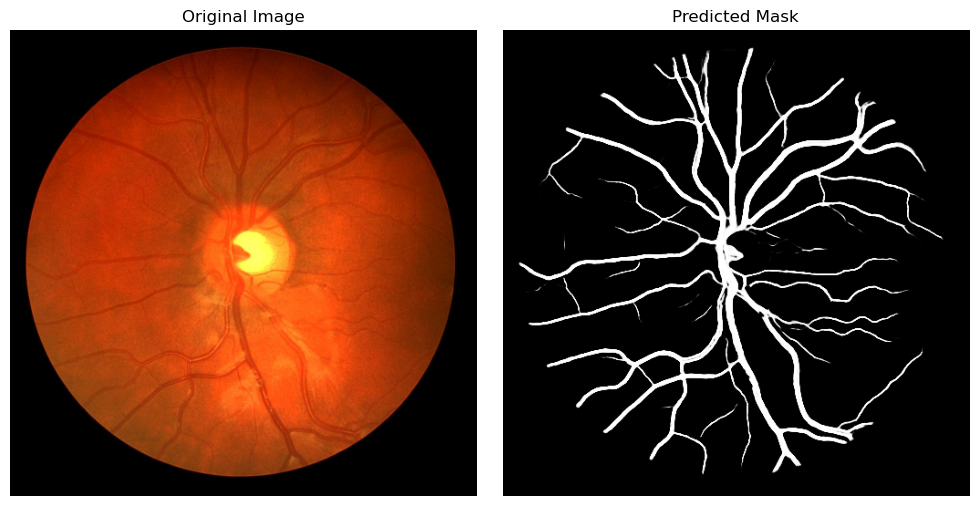

In [21]:
# Validate and process the test image for segmentation
if not os.path.exists(new_image_path):
    print(f"Error: New image not found at {new_image_path}")
else:
    print(f"Processing new image: {new_image_path}")
    predicted_mask = predict_and_display(model, new_image_path, preprocessing=PREPROCESSING)